In [1]:
# import the needed packages
import pandas as pd
import stlearn as st
import scanpy as sc
import scanpy.external as sce
import squidpy as sq
import matplotlib.pyplot as plt
import os
import sys
import subprocess
import numpy as np
import anndata as ad
from anndata import AnnData
import matplotlib as mpl
import seaborn as sns

import monkeybread as mb

# make sure that we are in the right directory
print(os.getcwd())

# set the filenames we are looking at
filename1 = "S18-5464_A1"
filename2 = "S17-16194_A1"

/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)
/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/mnt/plummergrp/QuPath_0.4.4/BrCa


In [ ]:
# file 1
df = pd.read_csv("./"+filename1+".txt", sep='\t', lineterminator='\n')

# create the cell matrix
df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
# leave only protein names
df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
# drop DAP1 because it is inconsequential to the downstream analysis
df_mat = df_mat.drop(columns=["DAPI"])
# need to increase the index by 1 so that it doesn't start at 0
df_mat.index = df_mat.index + 1
# save it as a csv
df_mat.to_csv("./"+filename1+"_matrix.csv", index=True)

# create the metadata file
df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
# calculate the cytoplasm as the cell minus the nucleus
df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
# need to increase the index by 1 so that it doesn't start at 0
df_meta.index = df_meta.index + 1
# save it as a csv
df_meta.to_csv("./"+filename1+"_metadata.csv", index=True)

# file 2
df = pd.read_csv("./"+filename2+".txt", sep='\t', lineterminator='\n')

# create the cell matrix
df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
# leave only protein names
df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
# drop DAP1 because it is inconsequential to the downstream analysis
df_mat = df_mat.drop(columns=["DAPI"])
# need to increase the index by 1 so that it doesn't start at 0
df_mat.index = df_mat.index + 1
# save it as a csv
df_mat.to_csv("./"+filename2+"_matrix.csv", index=True)

# create the metadata file
df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
# calculate the cytoplasm as the cell minus the nucleus
df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
# need to increase the index by 1 so that it doesn't start at 0
df_meta.index = df_meta.index + 1
# save it as a csv
df_meta.to_csv("./"+filename2+"_metadata.csv", index=True)

/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


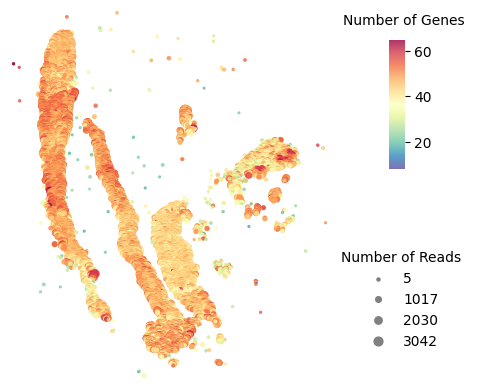

AnnData object with n_obs × n_vars = 56095 × 65
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


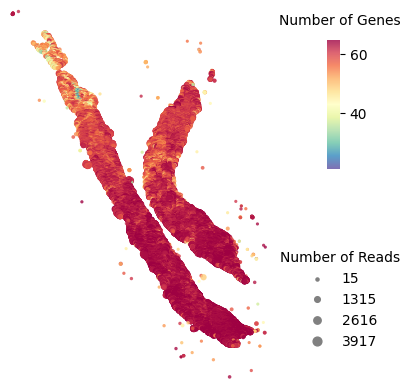

AnnData object with n_obs × n_vars = 164305 × 65
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


In [2]:
# load the data into Anndata

# data1
count_matrix = pd.read_csv('./'+filename1+'_matrix.csv', index_col=0)
spatial = pd.read_csv('./'+filename1+'_metadata.csv', index_col=0)
spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

adata1 = st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white")
st.pl.QC_plot(adata1)
print(adata1)

# data2
count_matrix = pd.read_csv('./'+filename2+'_matrix.csv', index_col=0)
spatial = pd.read_csv('./'+filename2+'_metadata.csv', index_col=0)
spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

adata2 = st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white")
st.pl.QC_plot(adata2)
print(adata2)

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# produce gene expression plots
for gene in genes:
    st.pl.gene_plot(adata, gene_symbols=gene)

# run clustering to filter ot all the StarDist artifacts
# make a copy
adata_art = adata.copy()

# basic preprocessing
st.pp.filter_genes(adata_art,min_cells=1)
st.pp.normalize_total(adata_art)
st.pp.log1p(adata_art)

# run PCA
st.em.run_pca(adata_art,n_comps=9)

# louvain clustering 
st.pp.neighbors(adata_art,n_neighbors=20,use_rep='X_pca')
st.tl.clustering.louvain(adata_art, resolution=0.5)
st.pl.cluster_plot(adata_art,use_label="louvain", size=1)

In [5]:
# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [ ]:
# normalize the datasets individually
st.pp.filter_genes(adata1,min_cells=1)
clr_normalize_each_cell(adata1)

st.pp.filter_genes(adata2,min_cells=1)
clr_normalize_each_cell(adata2)

# combine the datasets
adata = adata1.concatenate(adata2)

# save the anndata!
adata.write_h5ad('./session_file.h5ad')

# copy anndata for other batch correction techniques
adata_bbknn = adata.copy()
adata_scanorama = adata.copy()

# HARMONY CURRENTLY DOESN'T WORK!
# rename the batch names
adata.obs['batch'] = pd.Categorical(adata.obs['batch'])
adata.obs['batch'] = adata.obs['batch'].cat.rename_categories({'0': 'sample1', '1': 'sample2'})

# run pca and then harmony
sc.tl.pca(adata)
sce.pp.harmony_integrate(adata, 'batch')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

# save the anndata
adata.write_h5ad('./session_file_adata.h5ad')
adata

In [ ]:
# new way of running harmonypy using a python script instead
# first run the following commands in the shell:
# export NUM_THREADS=1
# export OPENBLAS_NUM_THREADS=1
# export OMP_NUM_THREADS=1

# now run the python script
# python RunHarmony.py

In [ ]:
# load anndata
adata = ad.read_h5ad('./session_file_felipe.h5ad')
# adata = ad.read_h5ad('./session_file.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

# calculate nneighbours
st.pp.neighbors(adata,n_neighbors=30,use_rep='X_pca')

# run umap
st.em.run_umap(adata)

# run leiden clustering
sc.tl.leiden(adata, resolution=0.5)

# umap
sc.pl.umap(adata, color=['leiden', 'batch'], size=1)
adata

In [ ]:
# test out bbknn batch correction
import bbknn

# run pca, neighbors, umap, and leiden for preprocessing
sc.pp.pca(adata_bbknn)
sc.pp.neighbors(adata_bbknn, n_neighbors=30, use_rep='X_pca')
sc.tl.leiden(adata_bbknn, resolution=0.5)

# run bbknn batch correction
bbknn.ridge_regression(adata_bbknn, batch_key=['batch'], confounder_key=['leiden'])
sc.pp.pca(adata_bbknn)
bbknn.bbknn(adata_bbknn, batch_key='batch')
print(adata_bbknn)

# calculate nneighbours
st.pp.neighbors(adata_bbknn,n_neighbors=30,use_rep='X_pca')

# run umap
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=['batch'], size=1)


In [ ]:
# test out scanorama
import scanorama

# run scanorama batch correction
adata_scanorama = scanorama.correct_scanpy(adata_scanorama, return_dimred=True)
print(adata_scanorama)

# calculate nneighbours
st.pp.neighbors(adata_scanorama,n_neighbors=30,use_rep='X_scanorama')

# run umap
st.em.run_umap(adata_scanorama)
sc.pl.umap(adata_scanorama, color=['batch'], size=1)

In [ ]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='leiden', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata, genes, groupby='leiden', swap_axes=True)

In [ ]:
# map the clusters onto the tissues
adata_sample1 = adata[adata.obs['batch'] == 'sample1']
adata_sample2 = adata[adata.obs['batch'] == 'sample2']

adata_sample1.uns['spatial'] = adata1.uns['spatial']
adata_sample2.uns['spatial'] = adata2.uns['spatial']

st.pl.cluster_plot(adata_sample1,use_label="leiden", show_cluster_labels=True, size=1, figsize=(8, 8), title="Sample 1")
plt.show()
st.pl.cluster_plot(adata_sample2,use_label="leiden", show_cluster_labels=True, size=1, figsize=(8, 8), title="Sample 2")
plt.show()

In [ ]:
# proportion of clusters in each sample
plt_data_sample1={}
for v in adata_sample1.obs['leiden'].unique():
    plt_data_sample1[v]=adata_sample1[adata_sample1.obs['leiden']==v].shape[0]/adata_sample1.shape[0]*100

plt_data_sample2={}
for v in adata_sample2.obs['leiden'].unique():
    plt_data_sample2[v]=adata_sample2[adata_sample2.obs['leiden']==v].shape[0]/adata_sample2.shape[0]*100

df1 = pd.DataFrame.from_dict(plt_data_sample1,orient='index',columns=['Haitian'])    
df2 = pd.DataFrame.from_dict(plt_data_sample2,orient='index',columns=['African American'])    

df = pd.concat([df1,df2],axis=1)
df.T.plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Clusters (Leiden)")
plt.show()

In [ ]:
# neighbourhood analysis
# set up
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

sq.gr.spatial_neighbors(adata_sample1)
sq.gr.spatial_neighbors(adata_sample2)

# neighbourhood enrichment
sq.gr.nhood_enrichment(adata_sample1, cluster_key="leiden")
sq.gr.nhood_enrichment(adata_sample2, cluster_key="leiden")

sq.pl.nhood_enrichment(adata_sample1, cluster_key="leiden", method="average", figsize=(5, 5))
plt.show()
sq.pl.nhood_enrichment(adata_sample2, cluster_key="leiden", method="average", figsize=(5, 5))
plt.show()
# interaction matrix
sq.gr.interaction_matrix(adata_sample1, cluster_key="leiden")
sq.gr.interaction_matrix(adata_sample2, cluster_key="leiden")

sq.pl.interaction_matrix(adata_sample1, cluster_key="leiden", method="average", figsize=(5, 5))
plt.show()
sq.pl.interaction_matrix(adata_sample2, cluster_key="leiden", method="average", figsize=(5, 5))
plt.show()

In [ ]:
# save anndata
adata.write_h5ad('./session_file_adata.h5ad')
adata_sample1.write_h5ad('./session_file_adata_sample1.h5ad')
adata_sample2.write_h5ad('./session_file_adata_sample2.h5ad')

In [ ]:
# load anndata
adata = ad.read_h5ad('./session_file_adata.h5ad')
adata_sample1 = ad.read_h5ad('./session_file_adata_sample1.h5ad')
adata_sample2 = ad.read_h5ad('./session_file_adata_sample2.h5ad')

# niche analysis
other_cell_types = ['8','3']

niche_subtypes_sample1 = []
for cell, ct in zip(adata_sample1.obs.index, adata_sample1.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes_sample1.append('malignant/other')
    else:
        niche_subtypes_sample1.append(ct)
adata_sample1.obs['niche_subtypes'] = niche_subtypes_sample1
adata_sample1.obs['niche_subtypes'] = adata_sample1.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata_sample1.obs['niche_subtypes']))

niche_subtypes_sample2 = []
for cell, ct in zip(adata_sample2.obs.index, adata_sample2.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes_sample2.append('malignant/other')
    else:
        niche_subtypes_sample2.append(ct)
adata_sample2.obs['niche_subtypes'] = niche_subtypes_sample2
adata_sample2.obs['niche_subtypes'] = adata_sample2.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata_sample2.obs['niche_subtypes']))

adata_sample1.obsm['X_spatial'] = adata_sample1.obsm['spatial']
adata_sample2.obsm['X_spatial'] = adata_sample2.obsm['spatial']

immune_mask_sample1 = ~adata_sample1.obs['niche_subtypes'].isin([
    'malignant/other'
])
immune_mask_sample2 = ~adata_sample2.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors_sample1 = mb.calc.cellular_niches(
    adata_sample1,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask_sample1
)

adata_neighbors_sample2 = mb.calc.cellular_niches(
    adata_sample2,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask_sample2
)

# visualize the distribution of neighbourhood profile values for a subset of
# the cell types
sns.histplot(adata_neighbors_sample1.obs_vector('1'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('1')
plt.show()

sns.histplot(adata_neighbors_sample1.obs_vector('0'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('0')
plt.show()

sns.histplot(adata_neighbors_sample2.obs_vector('1'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('1')
plt.show()

sns.histplot(adata_neighbors_sample2.obs_vector('0'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('0')
plt.show()

# Subset cells
adata_neighbors_sub_sample1 = sc.pp.subsample(
    adata_neighbors_sample1, fraction=1/2, copy=True
)

adata_neighbors_sub_sample2 = sc.pp.subsample(
    adata_neighbors_sample2, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub_sample1,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub_sample1, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub_sample1, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

sc.tl.umap(adata_neighbors_sub_sample2,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub_sample2, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub_sample2, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

# Map each niche to a color so that plots are consistent
niche_to_color_sample1 = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors_sample1.obs['niche'])))
}

fig, ax = plt.subplots(1,1,figsize=(15,15))
sc.pl.embedding(
    adata_sample1,
    "spatial",
    color = 'niche',
    palette=niche_to_color_sample1,
    size=1,
    ax=ax,
    show=False
)
plt.show()

niche_to_color_sample2 = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors_sample2.obs['niche'])))
}

fig, ax = plt.subplots(1,1,figsize=(15,15))
sc.pl.embedding(
    adata_sample2,
    "spatial",
    color = 'niche',
    palette=niche_to_color_sample2,
    size=1,
    ax=ax,
    show=False,
)
plt.show()

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale the data
adata_sample1_scaled = adata_sample1.copy()
st.pp.scale(adata_sample1_scaled, zero_center=True)

adata_sample2_scaled = adata_sample2.copy()
st.pp.scale(adata_sample2_scaled, zero_center=True)

# create gene expression heatmap
sc.pl.heatmap(adata_sample1_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=8)
sc.pl.heatmap(adata_sample2_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=8)

# proportion of niches in each sample
plt_data_sample1={}
for v in adata_sample1.obs['niche'].unique():
    plt_data_sample1[v]=adata_sample1[adata_sample1.obs['niche']==v].shape[0]/adata_sample1.shape[0]*100

plt_data_sample2={}
for v in adata_sample2.obs['niche'].unique():
    plt_data_sample2[v]=adata_sample2[adata_sample2.obs['niche']==v].shape[0]/adata_sample2.shape[0]*100

df1 = pd.DataFrame.from_dict(plt_data_sample1,orient='index',columns=['Haitian'])    
df2 = pd.DataFrame.from_dict(plt_data_sample2,orient='index',columns=['African American'])    

df = pd.concat([df1,df2],axis=1)
df.T.plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

In [ ]:
# niche analysis of the combined data 
niche_subtypes = []
other_cell_types = ['8','3']

for cell, ct in zip(adata.obs.index, adata.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes.append('malignant/other')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = niche_subtypes
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))

adata.obsm['X_spatial'] = adata.obsm['spatial']
immune_mask = ~adata.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask
)

# Subset cells
adata_neighbors_sub = sc.pp.subsample(
    adata_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

print(adata)

In [ ]:
# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors.obs['niche'])))
}

adata_niche1 = adata[adata.obs['batch'] == 'sample1']
adata_niche2 = adata[adata.obs['batch'] == 'sample2']

fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(
    adata_niche1,
    "spatial",
    color = 'niche',
    palette=niche_to_color,
    size=1,
    ax=ax,
    show=False
)
plt.show()


fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(
    adata_niche2,
    "spatial",
    color = 'niche',
    palette=niche_to_color,
    size=1,
    ax=ax,
    show=False,
)
plt.show()

In [ ]:
# scale the data
adata_niche1_scaled = adata_niche1.copy()
st.pp.scale(adata_niche1_scaled, zero_center=True)

adata_niche2_scaled = adata_niche2.copy()
st.pp.scale(adata_niche2_scaled, zero_center=True)

# create gene expression heatmap
sc.pl.heatmap(adata_niche1_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=5)
sc.pl.heatmap(adata_niche2_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=5)

In [ ]:
# proportion of niches in each sample
plt_data_niche1={}
for v in adata_niche1.obs['niche'].unique():
    plt_data_niche1[v]=adata_niche1[adata_niche1.obs['niche']==v].shape[0]/adata_niche1.shape[0]*100

plt_data_niche2={}
for v in adata_niche2.obs['niche'].unique():
    plt_data_niche2[v]=adata_niche2[adata_niche2.obs['niche']==v].shape[0]/adata_niche2.shape[0]*100

df1 = pd.DataFrame.from_dict(plt_data_niche1,orient='index',columns=['Haitian'])    
df2 = pd.DataFrame.from_dict(plt_data_niche2,orient='index',columns=['African American'])    

df = pd.concat([df1,df2],axis=1)
df.T.plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

In [ ]:
# load in the astir generated cell types and plot onto the tissues
celltypes1 = pd.read_csv('./'+filename1+'_cell-types.csv', index_col=0)['cell_type']
celltypes2 = pd.read_csv('./'+filename2+'_cell-types.csv', index_col=0)['cell_type']

adata1.obs['celltypes'] = celltypes1.to_numpy()
adata2.obs['celltypes'] = celltypes2.to_numpy()
adata1.obs['celltypes'] = adata1.obs['celltypes'].astype('category')
adata2.obs['celltypes'] = adata2.obs['celltypes'].astype('category')

set_celltypes = {'Normal Epithelial cells',
                 'Tumor cells', 
                 'Proliferating Tumor cells',
                 'Myoepithelial cells',
                 'Granulocytes',
                 'Telocytes',
                 'Endothelial cells',
                 'M2 Macrophages',
                 'M1 Macrophages',
                 'Fibroblasts',
                 'B cells',
                 'Cytotoxic T cells',
                 'Tregs',
                 'Helper T cells',
                 'Unknown',
                 'Other'}

# Map each niche to a color so that plots are consistent
type_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set_celltypes))
}

fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(
    adata1,
    "spatial",
    color = 'celltypes',
    palette=type_to_color,
    size=2,
    ax=ax,
    show=False
)
plt.show()


fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(
    adata2,
    "spatial",
    color = 'celltypes',
    palette=type_to_color,
    size=2,
    ax=ax,
    show=False,
)
plt.show()

/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Scale step is finished in adata.X


/mnt/storage1/conda/envs/stlearn/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


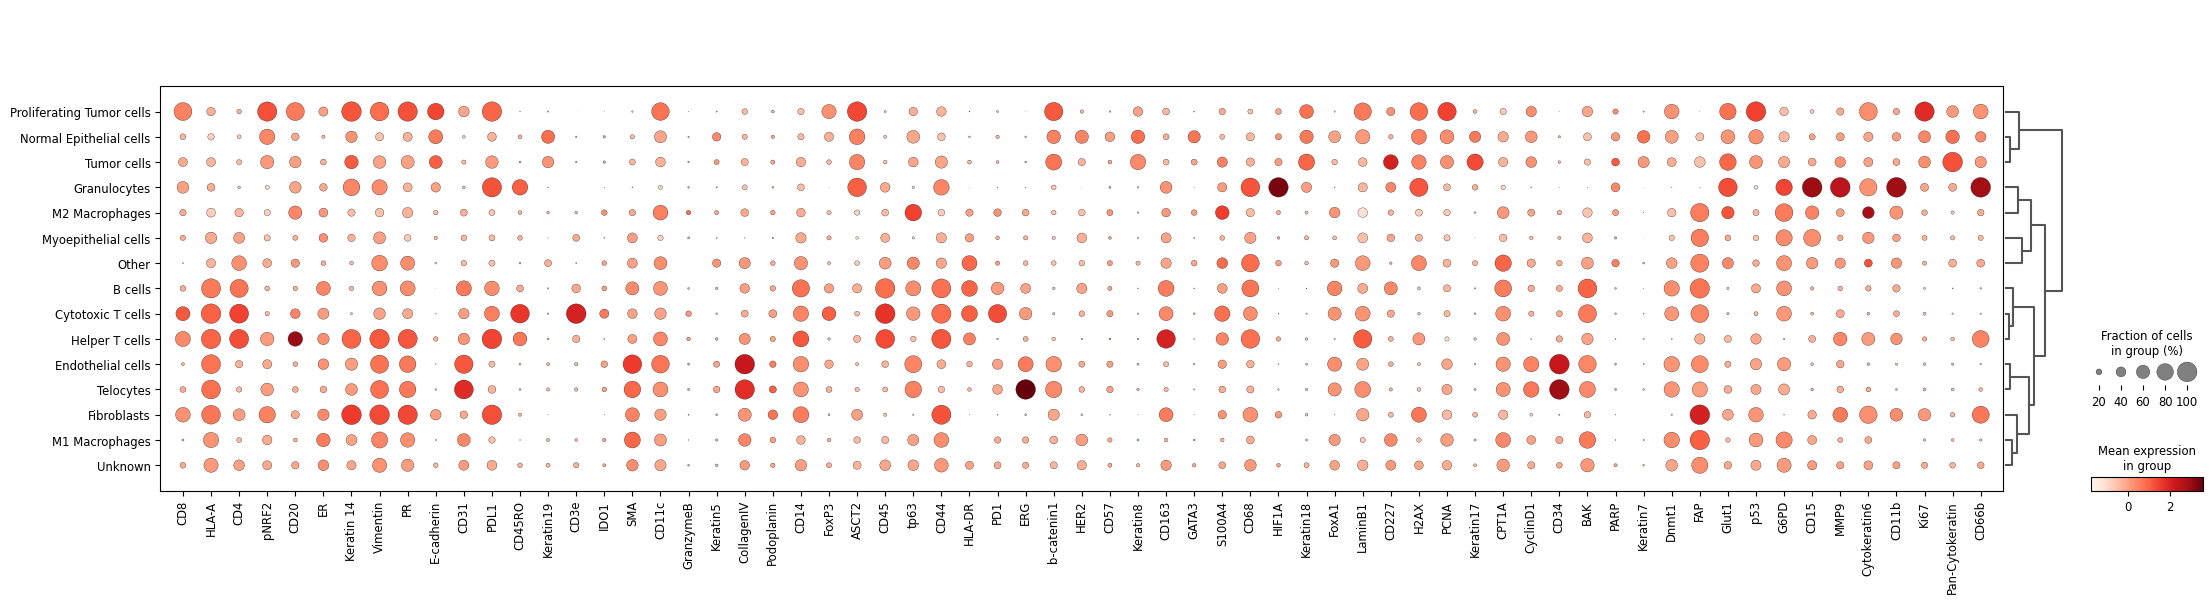

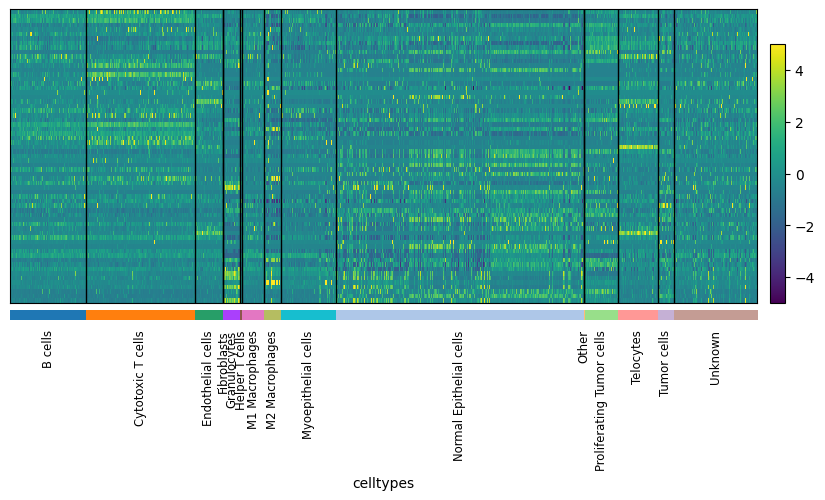

In [8]:
# generate heatmap and dotplot grouped by the cell types
# load anndata
adata = ad.read_h5ad('./session_file_felipe.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
temp_adata = adata1.concatenate(adata2)
adata.obs['celltypes'] = temp_adata.obs['celltypes']

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='celltypes', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='celltypes', swap_axes=True, vmin=-5, vmax=5)


In [ ]:
# plot individual cell types
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(
    adata1[adata1.obs['celltypes']=='Cytotoxic T cells'],
    "spatial",
    color = 'celltypes',
    palette=type_to_color,
    size=2,
    ax=ax,
    show=False,
)
plt.show()

In [ ]:
# run spatial-LDA
